# Soccer master

## Model training

This is the model training part of the project and for this you'll require the data file which is generated after running soccer_master_eda.ipynb

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,  VotingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Pre-processed data loading

In [3]:
transfer_data = pd.read_csv("C:\\Users\\devdp\\OneDrive\\Documents\\Github\\UMBC\\soccer_master\\data\\transfers_data.csv")
transfer_data.head()

,player_id,from_club_id,to_club_id,transfer_fee,market_value_in_eur,season,home_games,playing_formation,appearances,goals_per_game,...,win_percentage,draw_percentage,home_win_percentage,away_win_percentage,position,sub_position,foot,avg_market_value_of_last_seasons,age_at_transfer,transfer_diff
0,3333,10161,399,0.0,0.0,2002,35.0,4-2-3-1,68.0,0.000000,...,0.208333,0.263889,0.316993,0.088889,Goalkeeper,Goalkeeper,left,1.500000e+06,16.0,0.0
1,3333,399,352,0.0,0.0,2003,32.0,5-3-2,62.0,0.086207,...,0.371473,0.356322,0.464706,0.272321,Defender,Left-Back,left,8.000000e+05,17.0,0.0
2,3333,352,399,0.0,0.0,2003,15.0,4-1-4-1,29.0,0.137931,...,0.620690,0.241379,0.866667,0.357143,Attack,Centre-Forward,right,5.500000e+07,17.0,0.0
3,3333,399,762,7400000.0,7400000.0,2004,255.0,4-3-3 Attacking,501.0,0.060938,...,0.679278,0.161885,0.767983,0.580309,Midfield,Central Midfield,right,2.966667e+07,18.0,0.0
4,3333,762,405,0.0,5500000.0,2005,12.0,3-4-1-2,28.0,0.000000,...,0.035714,0.250000,0.000000,0.062500,Defender,Left-Back,left,1.000000e+06,19.0,-5500000.0


In [4]:
def process_formation_data(dataframe, training_year_threshold):
    """
    Process and standardize formation data by replacing rare formations.

    Args:
        dataframe: Transfer data DataFrame
        training_year_threshold: Year to split training data

    Returns:
        DataFrame with processed formation data
    """
    processed_df = dataframe.copy()

    # Identify common formations (10+ occurrences) in training data
    formation_frequency = processed_df[processed_df['season'] < training_year_threshold]['playing_formation'].value_counts()
    frequent_formations = formation_frequency[formation_frequency >= 10].index

    # Standardize rare and missing formations
    processed_df.loc[~processed_df['playing_formation'].isin(frequent_formations), 'playing_formation'] = 'Other'
    processed_df['playing_formation'] = processed_df['playing_formation'].fillna('Unknown')

    return processed_df

def prepare_model_data(dataframe, training_year_threshold=2023):
    """
    Prepare data for model training by splitting and identifying feature types.

    Args:
        dataframe: Transfer data DataFrame
        training_year_threshold: Year to split training/test data (default: 2023)

    Returns:
        X_train, X_test, y_train, y_test, categorical_features, numerical_features
    """
    processed_df = process_formation_data(dataframe, training_year_threshold)

    # Split data by year
    train_data = processed_df[processed_df['season'] < training_year_threshold].copy()
    test_data = processed_df[processed_df['season'] >= training_year_threshold].copy()

    # Separate features and target
    X_train = train_data.drop(['transfer_fee'], axis=1)
    y_train = train_data['transfer_fee']
    X_test = test_data.drop(['transfer_fee'], axis=1)
    y_test = test_data['transfer_fee']

    # Identify feature types
    categorical_features = ['position', 'sub_position', 'foot', 'playing_formation']
    numerical_features = [col for col in X_train.columns if col not in categorical_features]

    return X_train, X_test, y_train, y_test, categorical_features, numerical_features

In [5]:
def transform_features(features_df, categorical_columns, numerical_columns, existing_transformer=None):
    """
    Transform features using preprocessing pipeline for model training/inference.

    Args:
        features_df: Feature DataFrame
        categorical_columns: List of categorical feature names
        numerical_columns: List of numerical feature names
        existing_transformer: Optional fitted transformer for inference

    Returns:
        transformed_features: Preprocessed feature matrix
        transformer: Fitted transformer pipeline
    """
    feature_preprocessor = ColumnTransformer([
        ('numerical', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_columns),
        ('categorical', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
        ]), categorical_columns)
    ])

    preprocessing_pipeline = Pipeline([
        ('preprocessor', feature_preprocessor),
    ])

    if existing_transformer is None:
        transformed_features = preprocessing_pipeline.fit_transform(features_df)
        return transformed_features, preprocessing_pipeline
    else:
        transformed_features = existing_transformer.transform(features_df)
        return transformed_features, existing_transformer

### Data Preparation Pipeline

1. Split data into training/test sets (Using transfers before 2021 as training and rest as test data)
2. Transform features using preprocessing pipeline
3. Ensure consistent preprocessing across train/test data

In [6]:
print("\nInitiating data preparation pipeline...")

# Split data into train and test sets
X_train, X_test, y_train, y_test, categorical_features, numerical_features = prepare_model_data(transfer_data, training_year_threshold=2021)

print("\nData preparation pipeline initiated successfully!")
print(f"✓ Data split complete: {len(X_train)} training samples, {len(X_test)} test samples")

# Transform training data and get fitted transformer
X_train_transformed, feature_transformer = transform_features(
    X_train,
    categorical_features,
    numerical_features
)
print(f"✓ Training data transformed: {X_train_transformed.shape[1]} features generated")

# Transform test data using fitted transformer
X_test_transformed, _ = transform_features(
    X_test,
    categorical_features,
    numerical_features,
    existing_transformer=feature_transformer
)
print(f"✓ Test data transformed: {X_test_transformed.shape[1]} features generated")

print("\nData preparation completed successfully!")


Initiating data preparation pipeline...

Data preparation pipeline initiated successfully!
✓ Data split complete: 46502 training samples, 15067 test samples
✓ Training data transformed: 66 features generated
✓ Test data transformed: 66 features generated

Data preparation completed successfully!


### Model Training and Optimization
Implements grid search optimization for multiple regressors:
- Random Forest
- XGBoost
- Gradient Boosting
Includes hyperparameter tuning and model evaluation.

In [7]:
def optimize_regressor(model, param_grid, features, target, cv_folds=2):
    """
    Optimize regressor using grid search cross-validation.
    """
    print(f"\nOptimizing {model.__class__.__name__}...")

    optimizer = GridSearchCV(
        model,
        param_grid,
        cv=cv_folds,
        scoring='r2',
        n_jobs=-1,
        verbose=2
    )
    optimizer.fit(features, target)

    print(f"✓ Best R² score: {optimizer.best_score_:.3f}")

    return {
        'model': optimizer.best_estimator_,
        'best_params': optimizer.best_params_,
    }

# Define models and parameter grids
model_configs = [
    (RandomForestRegressor(), {
        'n_estimators': [100, 300],
        'max_depth': [3, 5, 7]
    }),
    (XGBRegressor(), {
        'n_estimators': [100, 300],
        'learning_rate': [0.1, 0.01],
        'max_depth': [5]
    }),
    (GradientBoostingRegressor(), {
        'n_estimators': [100, 300],
        'learning_rate': [0.1],
        'max_depth': [5]
    })
]

print("Starting model optimization...")
optimization_results = []

# Train and optimize each model
for model, params in model_configs:
    result = optimize_regressor(model, params, X_train_transformed, y_train)
    optimization_results.append(result)

# Print optimization results
print("\nOptimization Results Summary:")
for model_name, result in zip(
    ['Random Forest', 'XGBoost', 'Gradient Boosting'],
    optimization_results
):
    print(f"\n{model_name}:")
    print(f"Best parameters: {result['best_params']}")

# Extract best models
best_rf, best_xgb, best_gb = [result['model'] for result in optimization_results]
print("\nModel optimization completed successfully!")

Starting model optimization...

Optimizing RandomForestRegressor...
Fitting 2 folds for each of 6 candidates, totalling 12 fits
✓ Best R² score: 0.963

Optimizing XGBRegressor...
Fitting 2 folds for each of 4 candidates, totalling 8 fits
✓ Best R² score: 0.922

Optimizing GradientBoostingRegressor...
Fitting 2 folds for each of 2 candidates, totalling 4 fits
✓ Best R² score: 0.975

Optimization Results Summary:

Random Forest:
Best parameters: {'max_depth': 7, 'n_estimators': 100}

XGBoost:
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Gradient Boosting:
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

Model optimization completed successfully!


### Ensemble Model
Combines optimized models using VotingRegressor for final predictions

In [8]:
print("Creating ensemble model...")

# Define model ensemble
regressor_ensemble = [
    ('random_forest', best_rf),
    ('xgboost', best_xgb),
    ('gradient_boosting', best_gb)
]

ensemble_model = VotingRegressor(regressor_ensemble)

# Train ensemble
ensemble_model.fit(X_train_transformed, y_train)

# Generate predictions
train_predictions = ensemble_model.predict(X_train_transformed)

print("✓ Ensemble model trained successfully")

Creating ensemble model...
✓ Ensemble model trained successfully


In [9]:
print('R2 Score of voting ensamble model:', r2_score(y_train, train_predictions))

R2 Score of voting ensamble model: 0.9980362054581483


### Model Evaluation
Evaluates models on both training and test data using R² score

Evaluating model performance...

Model Performance Metrics:
               Model  Train_R2   Test_R2
0      Random Forest  0.994055  0.976555
1            XGBoost  0.992759  0.918059
2  Gradient Boosting  0.999920  0.982389
3           Ensemble  0.998036  0.975350


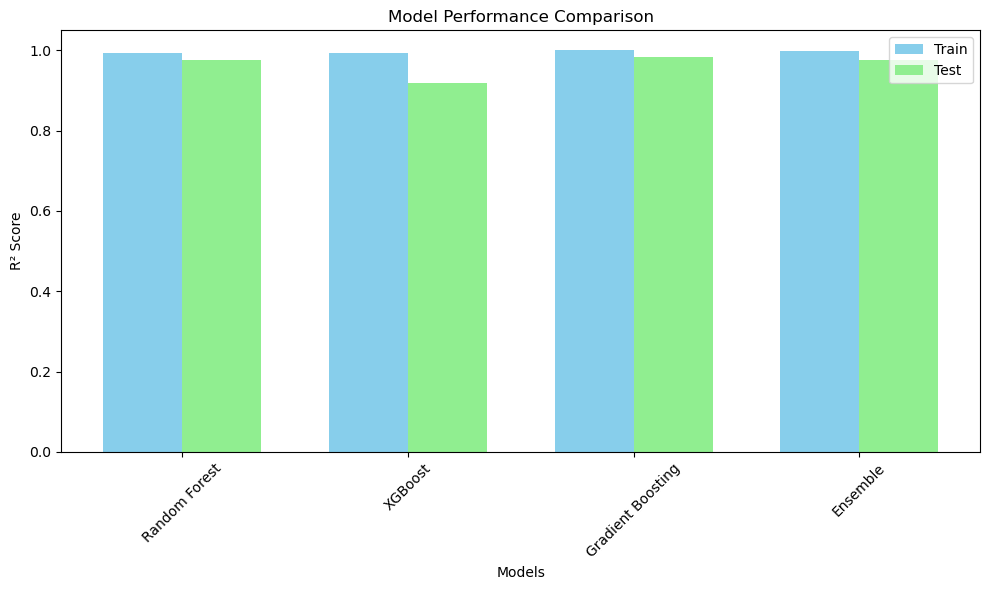

In [10]:
def evaluate_model_performance(train_features, train_target, test_features, test_target, models, model_names):
    """
    Evaluate and visualize model performance on train and test data
    """
    print("Evaluating model performance...")

    performance_metrics = {
        'Model': [],
        'Train_R2': [],
        'Test_R2': []
    }

    # Calculate metrics for each model
    for name, model in zip(model_names, models):
        train_predictions = model.predict(train_features)
        test_predictions = model.predict(test_features)

        performance_metrics['Model'].append(name)
        performance_metrics['Train_R2'].append(r2_score(train_target, train_predictions))
        performance_metrics['Test_R2'].append(r2_score(test_target, test_predictions))

    # Create performance DataFrame
    results_df = pd.DataFrame(performance_metrics)
    print("\nModel Performance Metrics:")
    print(results_df)

    # Visualize results
    plt.figure(figsize=(10, 6))
    x = np.arange(len(model_names))
    width = 0.35

    plt.bar(x - width/2, performance_metrics['Train_R2'], width, label='Train', color='skyblue')
    plt.bar(x + width/2, performance_metrics['Test_R2'], width, label='Test', color='lightgreen')

    plt.title('Model Performance Comparison')
    plt.ylabel('R² Score')
    plt.xlabel('Models')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results_df

# Define model names
model_names = ['Random Forest', 'XGBoost', 'Gradient Boosting', 'Ensemble']
best_models = [best_rf, best_xgb, best_gb]
# Evaluate models
results = evaluate_model_performance(
    X_train_transformed, y_train,
    X_test_transformed, y_test,
    best_models + [ensemble_model],
    model_names
)

In [11]:
# Save trained models and preprocessing pipeline
import joblib
model_path = 'C:\\Users\\devdp\\OneDrive\\Documents\\Github\\UMBC\\soccer_master\\'
joblib.dump(ensemble_model, model_path+'ensemble_model.joblib')
joblib.dump(feature_transformer, model_path+'feature_transformer.joblib')
print("✓ Models saved successfully:")
print(f"  - Ensemble model: {model_path+'ensemble_model.joblib'}")
print(f"  - Feature transformer: {model_path+'feature_transformer.joblib'}")

✓ Models saved successfully:
  - Ensemble model: C:\Users\devdp\OneDrive\Documents\Github\UMBC\soccer_master\ensemble_model.joblib
  - Feature transformer: C:\Users\devdp\OneDrive\Documents\Github\UMBC\soccer_master\feature_transformer.joblib


# Sample test-case

objective is to find transfer value of player named Ousmane Dembélé from dortmund to barcelona (player id is `288230`)

In [12]:
def format_currency(number):
    """
    Format number as currency with thousands separators (e.g., 35,000,000)
    """
    return "{:,.0f}".format(number)

In [13]:
def predict_player_transfer(player_id, data, model, transformer, categorical_cols, numerical_cols):
    """
    Predict transfer fee for a specific player
    """
    # Get player data
    player_data = data.query(f'player_id=={player_id}').iloc[1]
    actual_fee = player_data["transfer_fee"]

    # Prepare features
    features = pd.DataFrame(player_data.drop("transfer_fee")).T
    transformed_features, _ = transform_features(
        features,
        categorical_cols,
        numerical_cols,
        existing_transformer=transformer
    )

    # Make prediction
    predicted_fee = model.predict(transformed_features)[0]

    print(f"\nTransfer Fee Prediction:")
    print(f"Predicted: {format_currency(predicted_fee)} euros")
    print(f"Actual: {format_currency(actual_fee)} euros")
    print(f"Difference: {format_currency(abs(predicted_fee - actual_fee))} euros")

    return predicted_fee, actual_fee

In [14]:
# Predict transfer fee
predicted_fee, actual_fee = predict_player_transfer(
    288230,
    transfer_data,
    ensemble_model,
    feature_transformer,
    categorical_features,
    numerical_features
)


Transfer Fee Prediction:
Predicted: 55,153,072 euros
Actual: 55,000,000 euros
Difference: 153,072 euros
